# Modules

In [3]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

from scipy.interpolate import splev, splrep, interp1d
import scipy.optimize as opt
from scipy.signal import find_peaks

import glob

from pdastro import *

# Definitions

In [9]:
def diff(params, f_tmp, f_tmp_err, f_obs, f_obs_err):
    """calculate the difference between two light curves"""
    a, b = params
    f_obs_new = a * f_obs + b
    err = np.sqrt(f_tmp_err**2+f_obs_err**2)
    chi2 = (f_obs_new - f_tmp)**2 / err**2
    
    return np.sum(chi2)


def find_t_peak(t, f, t_range=None):
    if t_range is None:
        t_peak = t[np.argmax(f)]
    else:
        t_min = t_range[0]
        t_max = t_range[1]
        f = f[(t<t_max) & (t>t_min)]
        t = t[(t<t_max) & (t>t_min)]
        t_peak = t[np.argmax(f)]
    
    return t_peak


def find_t_shift(t1, f1, t2, f2, t_range=None):
    t_peak1 = find_t_peak(t1, f1, t_range=t_range)
    t_peak2 = find_t_peak(t2, f2, t_range=t_range)
    
    return t_peak2 - t_peak1


def get_tshift_scale_offset(t1, f1, f1_err, t2, f2, f2_err, t_range=None, t_peaks=None):
    """get optimized scale factor tshift, a, b
    t1, f1: template 
    t2, f2: f2_new = a * f2 + b
    """

    if t_peaks is None:
        if t_range is None:
            tshift = find_t_shift(t1, f1, t2, f2)
        elif t_range is not None:
            tshift = find_t_shift(t1, f1, t2, f2, t_range=t_range)
    elif t_peaks is not None:
        tshift = t_peaks[1] - t_peaks[0]
    
    t2_shifted = t2 - tshift

    tmin = max(t1.min(), t2_shifted.min())
    tmax = min(t1.max(), t2_shifted.max())
    
    t_range = t2_shifted[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    
    f1_new = splev(t_range, splrep(t1[::2], f1[::2], k=1))
    f1_new_err = splev(t_range, splrep(t1[::2], f1_err[::2], k=1))
    f2_new = f2[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    f2_new_err = f2_err[(t2_shifted>tmin) & ((t2_shifted<=tmax))]
    
    # get optimzied scale f2_new = a * f2 + b
    guess = (1, 0)
    res = opt.minimize(diff, guess, args=(f1_new, f1_new_err, f2_new, f2_new_err))
    a, b = res['x'][0], res['x'][1]
    
    return tshift, a, b

In [20]:
def lc_indices(df, n_sigma=3.0, nerr_sigma=3.0):
    "return the indices of the table of usable values"
    
    jyas2_med = np.nanmedian(df['Jyas2'])
    jyas2_std = np.nanstd(df['Jyas2'])
    jyas2err_med = np.nanmedian(df['Jyas2_err'])
    jyas2err_std = np.nanstd(df['Jyas2_err'])

    if nerr_sigma!=None:
        inds = np.where((df['Jyas2_err']< jyas2err_med + nerr_sigma*jyas2err_std) & (abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std))[0]
    else:
        # inds = np.where((df['Jyas2_err']< jyas2err_med + 0.34e-6) & (abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std))[0]   # this was for ec0814
        # inds = np.where((abs(df['Jyas2'])< jyas2_med + n_sigma*jyas2_std) & (df['Jyas2_err']<1.0e-6))[0]
        inds = np.where((df['fluxADU']< 1000) & (df['Jyas2_err']<1.0e-6))[0]
        
    return(inds)



def get_bins(df, t):
    t_range = np.linspace(min(t),max(t),100)
    skip_inds = []
    bins_t = []
    t_bvals = [t_range[0]]
    for i in range(len(t_range)-1):
        # if i not in skip_inds:
            lo_i = i
            skip_inds.append(i)
            up_i = i+1
            # bin_i = np.where((df.t['mjd']>t_range[lo_i]) & (df.t['mjd']<t_range[up_i]))[0]
            bin_i = df.ix_inrange('mjd', lowlim=t_range[lo_i], uplim=t_range[up_i])
            while len(bin_i)<50 and up_i!=len(t_range)-1:
                skip_inds.append(up_i)
                up_i += 1
                bin_i = df.ix_inrange('mjd', lowlim=t_range[lo_i], uplim=t_range[up_i])
                
            bins_t.append(bin_i)
            t_bvals.append(t_range[up_i])
    return(bins_t, t_bvals)


def get_LCbins(df, bin_sz):

    sort_inds = df.ix_sort_by_cols('mjd')

    bins_inds = []
    
    for i in range(0, len(sort_inds), bin_sz):
        if len(sort_inds) - (i+bin_sz) < bin_sz or len(sort_inds) - i < bin_sz:
            bins_inds.append(sort_inds[i:])
            break
        else:
            bins_inds.append(sort_inds[i:i + bin_sz])

    return(bins_inds)

In [64]:
def convert_Jy2mag(mJy):
    # mJy in micro-janskys
    mag = 23.9 - 2.5*np.log10(mJy)
    return(mag)



def get_mean_pix(img, x, y):
    """ get mean pixel values over 9 nearby pixels centered at (x, y)
        img: array
        x, y center"""
    mean = (img[y, x] + img[y, x-1] + img[y, x+1]
          + img[y-1,x]+ img[y-1,x-1]+ img[y-1,x+1]
          + img[y+1,x]+ img[y+1,x-1]+ img[y+1,x+1]).astype(np.float32)/9
    return mean

# Color Plot

In [58]:
### Read in Models
LCm2_i = pd.read_csv('ecLCi_m2.csv')
LCm2_g = pd.read_csv('ecLCg_m2.csv')

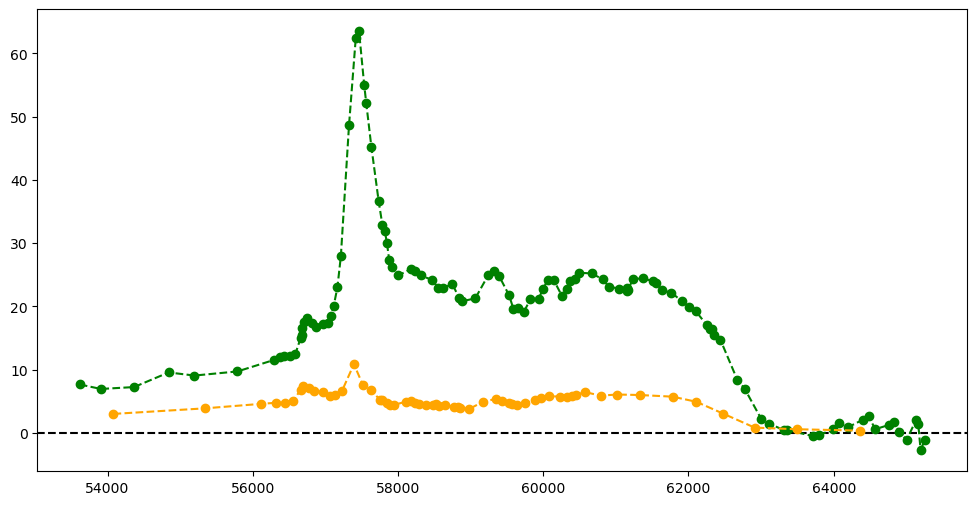

In [60]:
plt.subplots(dpi = 100, figsize = [12,6])
plt.errorbar(LCm2_i['mjd'], LCm2_i['mJyas2'], fmt='--o', ecolor='black', color='green', yerr=LCm2_i['mJyas2_err'])
plt.errorbar(LCm2_g['mjd'], LCm2_g['mJyas2'], fmt='--o', ecolor='black', color='orange', yerr=LCm2_g['mJyas2_err'])
plt.axhline(y=0, linestyle='--', color='black')

In [73]:
LCm2_i['AB_mag'] = convert_Jy2mag(abs(LCm2_i['mJyas2'].values))
LCm2_g['AB_mag'] = convert_Jy2mag(LCm2_g['mJyas2'].values)

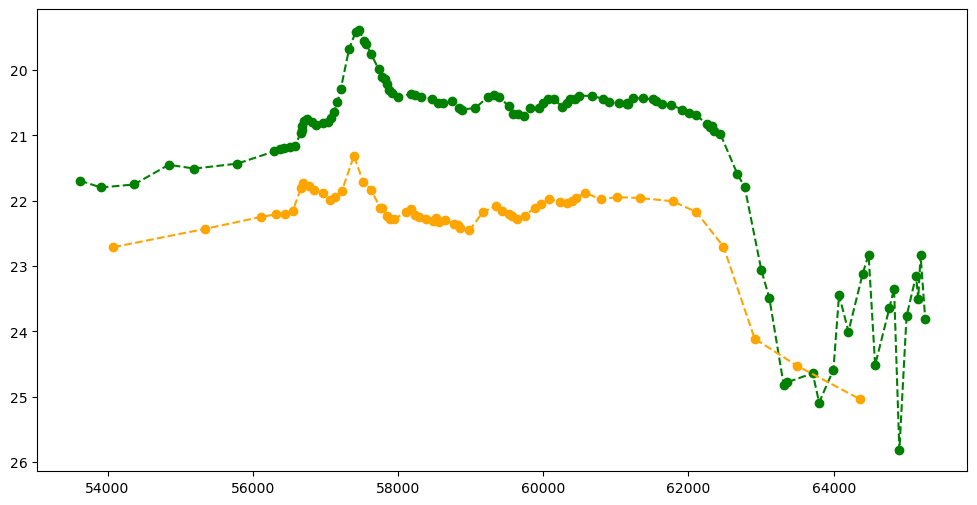

In [79]:
plt.subplots(dpi = 100, figsize = [12,6])
plt.errorbar(LCm2_i['mjd'], LCm2_i['AB_mag'], fmt='--o', ecolor='black', color='green')
plt.errorbar(LCm2_g['mjd'], LCm2_g['AB_mag'], fmt='--o', ecolor='black', color='orange')
plt.gca().invert_yaxis()

In [88]:
t_ran = np.arange(min(LCm2_g['mjd']), max(LCm2_g['mjd']))

i_new = splev(t_ran, splrep(LCm2_i['mjd'], LCm2_i['AB_mag'], k=1))
# i_new_err = splev(t_ran, splrep(LCm2_i['mjd'], LCm2_i['AB_mag_err'], k=1))
g_new = splev(t_ran, splrep(LCm2_g['mjd'], LCm2_g['AB_mag'], k=1))
# g_new_err = splev(t_ran, splrep(LCm2_g['mjd'], LCm2_g['AB_mag_err'], k=1))

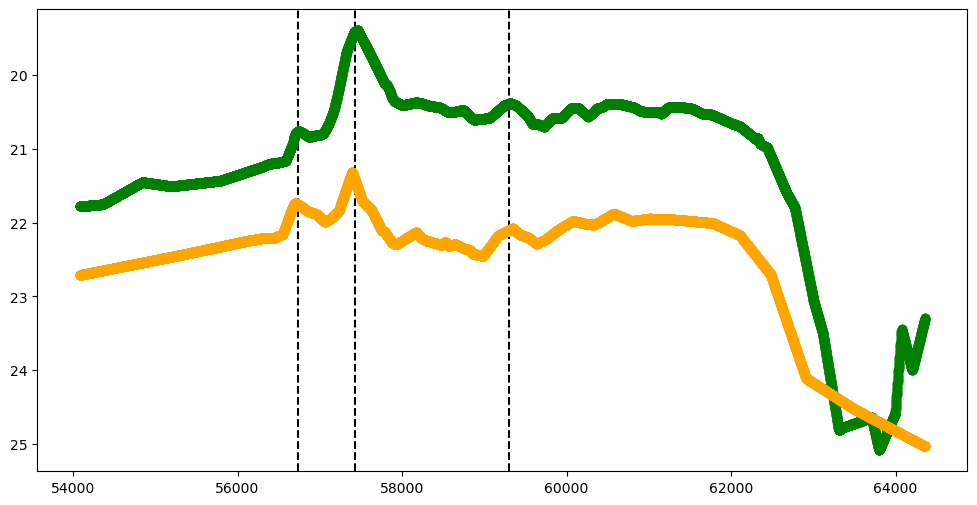

In [128]:
plt.subplots(dpi = 100, figsize = [12,6])
plt.errorbar(t_ran, i_new, fmt='--o', ecolor='black', color='green')
plt.errorbar(t_ran, g_new, fmt='--o', ecolor='black', color='orange')
plt.gca().invert_yaxis()

plt.axvline(56740, color='k', ls='--')
plt.axvline(57430, color='k', ls='--')
plt.axvline(59300, color='k', ls='--')

(54000.0, 63300.0)

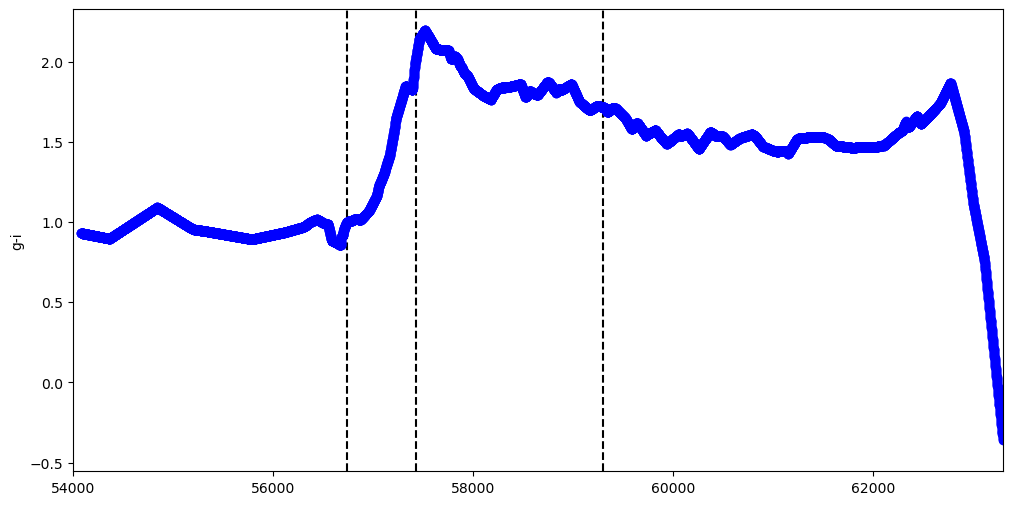

In [140]:
plt.subplots(dpi = 100, figsize = [12,6])
plt.errorbar(t_ran, g_new-i_new, fmt='--o', ecolor='black', color='blue')
plt.axvline(56740, color='k', ls='--')
plt.axvline(57430, color='k', ls='--')
plt.axvline(59300, color='k', ls='--')
plt.ylabel('g-i')
plt.xlim(54000, 63300)